In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import torchvision
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from helpers.cnn_model import CNNModel

In [2]:
# load the images in the data folder, divided into [1, 2, 3, 4, 5, 6] subfolders indicating the label

# transformations: to tensor, grayscale, normalize
transform = torchvision.transforms.Compose([
    # make tensor and therefore scale to [0, 1]
    torchvision.transforms.ToTensor(),
    # convert to grayscale
    torchvision.transforms.Grayscale(num_output_channels=1),
    # normalize to [-1, 1]
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# get the dataset and transform
dataset = torchvision.datasets.ImageFolder(root='data/', transform=transform)

# split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

data_train, data_val = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=32, shuffle=False)

# skip the test set for now

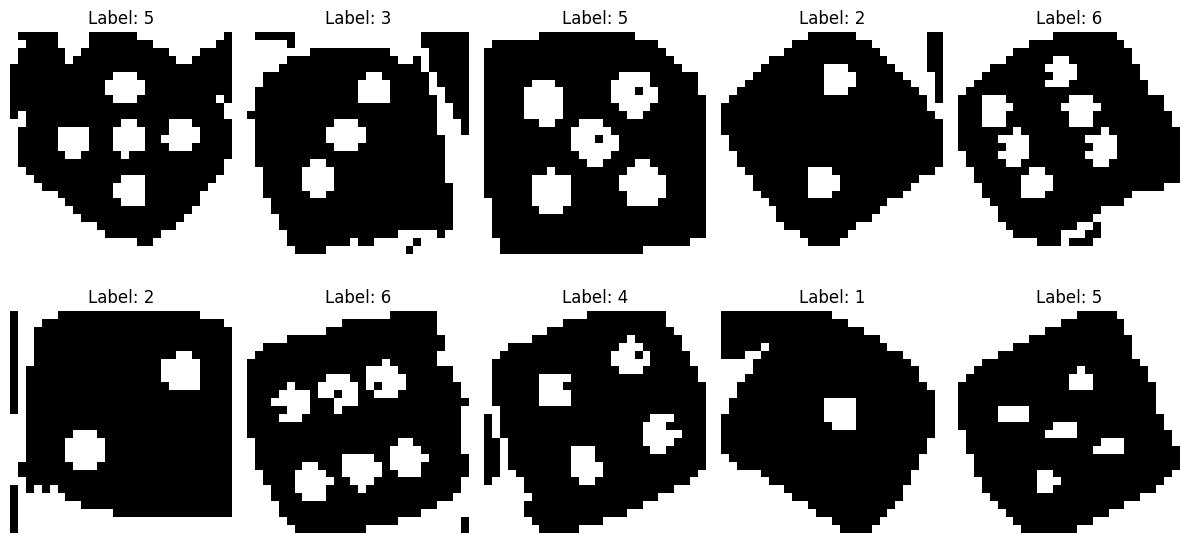

In [3]:
# inspect dataset by plotting some samples
indices = np.random.choice(len(data_train), 10, replace=False)
samples = [data_train[i] for i in indices]

# Plot the samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i, (image, label) in enumerate(samples):
    # Denormalize the image
    image = image.numpy().squeeze()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# training loop with validation and early stopping
def training_loop(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    no_improvement_epochs = 0
    patience = 5  # number of epochs to wait for improvement before stopping

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            no_improvement_epochs = 0

        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print("Early stopping triggered")

            # load the best model
            model.load_state_dict(torch.load('best_model.pth'))
            break 

    return train_losses, val_losses, val_accuracies

In [11]:
# initialise the model
model = CNNModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 100

In [12]:
# train the model
train_losses, val_losses, val_accuracies = training_loop(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch [1/100], Train Loss: 1.6572, Val Loss: 1.4422, Val Accuracy: 47.87%
Epoch [2/100], Train Loss: 1.1317, Val Loss: 0.8255, Val Accuracy: 83.30%
Epoch [3/100], Train Loss: 0.7038, Val Loss: 0.5435, Val Accuracy: 87.38%
Epoch [4/100], Train Loss: 0.5055, Val Loss: 0.4107, Val Accuracy: 91.28%
Epoch [5/100], Train Loss: 0.4121, Val Loss: 0.3438, Val Accuracy: 90.72%
Epoch [6/100], Train Loss: 0.3465, Val Loss: 0.3112, Val Accuracy: 91.84%
Epoch [7/100], Train Loss: 0.3000, Val Loss: 0.2638, Val Accuracy: 92.39%
Epoch [8/100], Train Loss: 0.2700, Val Loss: 0.2638, Val Accuracy: 92.21%
Epoch [9/100], Train Loss: 0.2347, Val Loss: 0.2273, Val Accuracy: 92.76%
Epoch [10/100], Train Loss: 0.2221, Val Loss: 0.2054, Val Accuracy: 94.62%
Epoch [11/100], Train Loss: 0.1971, Val Loss: 0.2020, Val Accuracy: 95.18%
Epoch [12/100], Train Loss: 0.1908, Val Loss: 0.1823, Val Accuracy: 95.36%
Epoch [13/100], Train Loss: 0.1731, Val Loss: 0.1789, Val Accuracy: 94.62%
Epoch [14/100], Train Loss: 0.1513

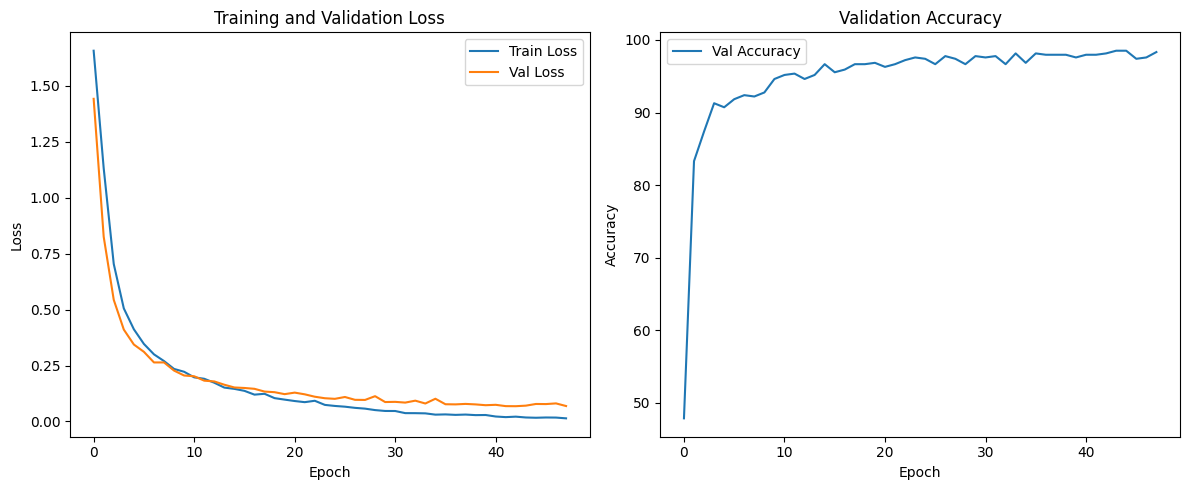

In [13]:
# plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

Top 1 Prediction: 2 with output value 99.94 %
Top 2 Prediction: 4 with output value 0.03 %
Top 3 Prediction: 1 with output value 0.02 %
Top 4 Prediction: 3 with output value 0.01 %
Top 5 Prediction: 6 with output value 0.00 %
Top 6 Prediction: 5 with output value 0.00 %
True Label: 2, Predicted Label: 2


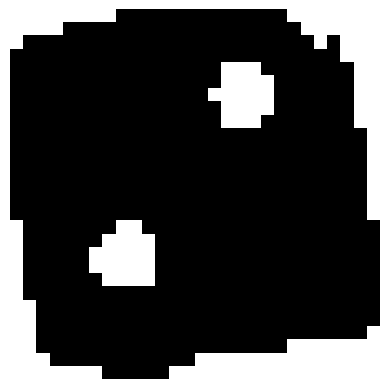

In [14]:
# plot one test sample and push through the model and display the result
model.eval()
with torch.no_grad():
    # random number from the size of the test_data_loader
    random_index = np.random.randint(0, len(data_val))
    image, label = data_val[random_index]

    output = model(image.unsqueeze(0))

    output = torch.softmax(output, dim=1)

    # give out the 6 most likely predictions
    top6_prob, top6_catid = torch.topk(output.data, 6)
    for i in range(6):
        print(f"Top {i+1} Prediction: {int(top6_catid[0][i]) + 1} with output value {100 * top6_prob[0][i].item():.2f} %")

    print(f'True Label: {label + 1}, Predicted Label: {int(torch.argmax(output)) + 1}')

    # plot
    image = image.numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
